# PRACTICE WITH TRANSFER FUNCTIONS

In [1]:
#!pip -q install tellurium
#!pip -q install control

In [2]:
import numpy as np
import pandas as pd
import tellurium as te
import control
import matplotlib.pyplot as plt

In [3]:
TIMES = np.linspace(0, 10, 100)

In [ ]:
s = control.TransferFunction.s

# Helpers

In [32]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
"""
TEST_RR = te.loada(TEST_MODEL)

In [34]:

k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
scale = TEST_RR["S1"]
tf = scale*k1*k2/(s*(s+k2))

TransferFunction(array([20.]), array([1., 2., 0.]))

In [35]:
def evaluateTransferFunction(model, transfer_function, output_name, times=TIMES,
                             is_plot=True):
    """
    Plots simulations versus predictions.

    Args:
        model: (str) antimony
        tranfer_function (control.TransferFunction)
        output_name: (str) prediction
        times: (np.darray)
    Returns:
        float
    """
    rr = te.loada(model)
    data = rr.simulate(times[0], times[-1], len(times))
    output_name = "[" + output_name + "]"
    simulations = data[output_name]
    _, predictions = control.forced_response(transfer_function, T=times, U=1)
    rmse = np.sqrt(np.sum(simulations-predictions)**2)/len(simulations)
    if is_plot:
        plt.scatter(simulations, predictions)
        maxval = max(np.max(predictions), np.max(simulations))
        plt.plot([0, maxval], [0, maxval], color="red")
        plt.xlabel("simulated")
        plt.ylabel("predicted")
    return rmse

rmse = evaluateTransferFunction(TEST_MODEL, tf, "S3", is_plot=False)
assert(rmse < 1e-5)
print("OK!")

OK!


In [45]:
def plotModel(model, times=TIMES, is_plot=True, title="", **kwargs):
    """
    Plots a model.
    
    Args:
       times: np.array 
       kwargs: values of parameters
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    rr.simulate(times[0], times[-1], len(times))
    if is_plot:
        rr.plot(title=title)
    
# TESTS
plotModel(TEST_MODEL, k1=0.1, is_plot=False)
print("OK1")

OK1


# Exercise 1: Sequential Network

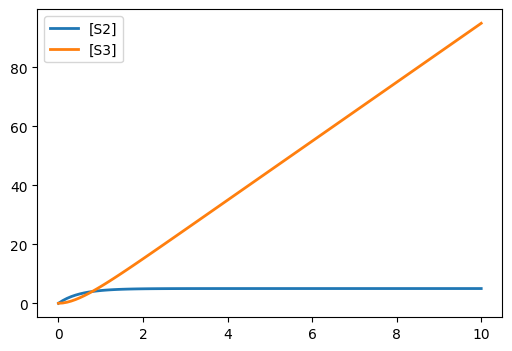

In [4]:
model1 = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
"""
RR = te.loada(model1)
DATA = RR.simulate(TIMES[0], TIMES[-1], len(TIMES))
RR.plot()

## System to analyze
* Input: $S_1$
* Output: $S_3$

## Step 1: Write the system equations
The system equations are the equations that describe the changes in the chemical species.

\begin{eqnarray}
\frac{dS_2}{dt} & = & k_1 S_1 - k_2 S_2 \\
\frac{d S_3}{dt} & = & k_2 S_2
\end{eqnarray}

## Step 2: Take the Laplace transform of the system equations

Property P1: The Laplace transform of the derivative is $s$ times its Laplace transform.

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) - k_2 S_2 (s) \\
s S_3 (s) & = & k_2 S_2 (s)
\end{eqnarray}

## Step 3: Solve for the output in terms of the input.

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) - k_2 S_2 (s) \\
S_2 (s) & = & \frac{k_1 S_1 (s)}{s + k_2}
\end{eqnarray}

\begin{eqnarray}
s S_3 (s) & = & k_2 S_2 (s) \\
S_3 (s) & = & \frac{k_2 S_2 (s)}{s}
\end{eqnarray}

## Step 4: Do backwards substitutions

\begin{eqnarray}
S_3 (s) & = & \frac{k_2 S_2 (s)}{s} \\
  & = &  \frac{k_1 k_2 S_1 (s)}{s(s + k_2)} \\
G(s) & = & \frac{S_3(s)}{S_1 (s)} \\
& = & \frac{k_1 k_2}{s (s + k_2)}
\end{eqnarray}

## 5. Check your transfer function
Use the python control library to predict a step response. The transfer function is expressed as a numerator polynomial in $s$ and a denominator polynomial in $s$.

In [5]:
s = control.TransferFunction.s
k1 = RR["k1"]
k2 = RR["k2"]
scale = RR["S1"]
tf = scale*k1*k2/(s*(s+k2))
tf

TransferFunction(array([20.]), array([1., 2., 0.]))

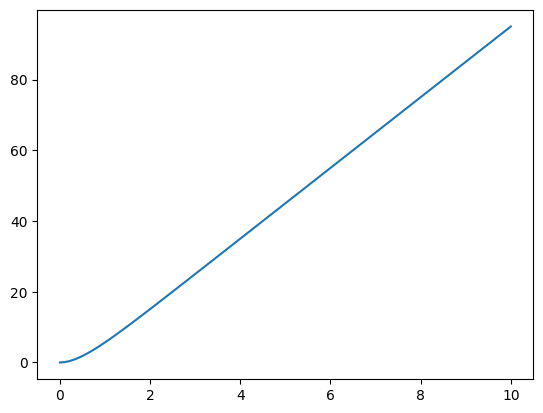

In [6]:
times, predictions = control.forced_response(tf, T=TIMES, U=1)
plt.plot(times, predictions)

Text(0, 0.5, 'predicted')

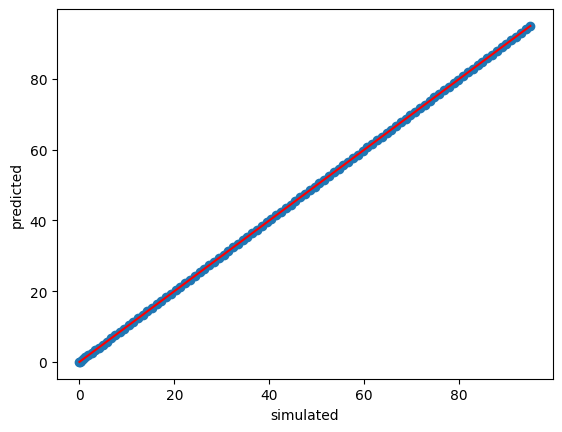

In [7]:
# Compare with simulation
plt.scatter(DATA["[S3]"], predictions)
maxval = np.max(predictions)
plt.plot([0, maxval], [0, maxval], color="red")
plt.xlabel("simulated")
plt.ylabel("predicted")

2.5154402494578788e-06

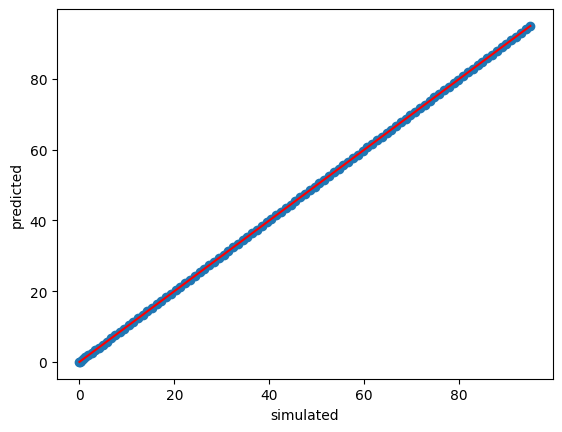

In [15]:
evaluateTransferFunction(model1, tf, "S3")

## Questions
1. What are the poles of the transfer function?
1. Is the system stable
1. What is the DC gain?

# Exercise 2: Sequential Network With Output Degradation

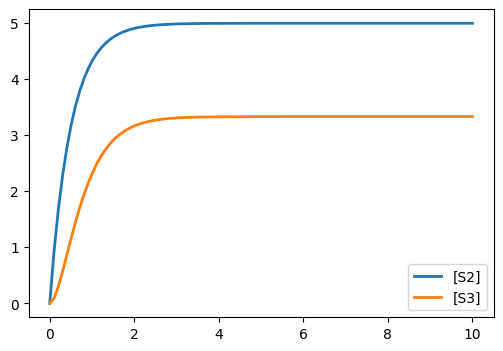

In [17]:
model2 = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""
RR2 = te.loada(model2)
DATA2 = RR2.simulate(TIMES[0], TIMES[-1], len(TIMES))
RR2.plot()

## Step 1: Write the system equations

\begin{eqnarray}
\frac{dS_2}{dt} & = & k_1 S_1 - k_2 S_2 \\
\frac{d S_3}{dt} & = & k_2 S_2 - k_3 S_3
\end{eqnarray}

## Step 2: Take Laplace transforms of the system equations

\begin{eqnarray}
s S_2(s) = k_1 S_1 (s) - k_2 S_2 (s) \\
s S_3 (s) = k_2 S_2 (s) - k_3 S_3(s) \\
\end{eqnarray}

## Step 3: Solve for the output in terms of the input for each system equation

## Step 4: Do backwards substitution to solve for the output in terms of the input

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) - k_2 S_2 (s) \\
S_2 (s) & = & \frac{k_1 S_1 (s)}{s + k_2}
\end{eqnarray}

\begin{eqnarray}
s S_3 (s) & = & k_2 S_2 (s) - k_3 S_3(s) \\
S_3 (s) & = & \frac{k_2 S_2 (s)}{s +k_3}
\end{eqnarray}

\begin{eqnarray}
S_3 (s) & = & \frac{k_2 }{s +k_3}\frac{k_1 S_1 (s)}{s + k_2} \\
G(s) & = & \frac{k_1 k_2 }{(s +k_2)(s + k_3)}
\end{eqnarray}

## Step 5: Check your transfer function

1.3374735365953573e-06

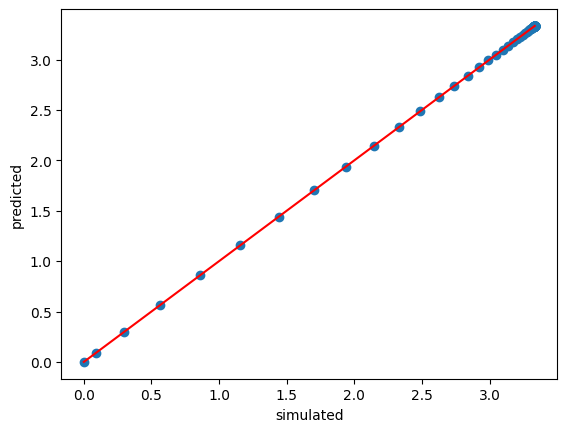

In [22]:
tf = RR["S1"]*RR2["k1"]*RR2["k2"]/((s + RR2["k2"])*(s + RR2["k3"]))
evaluateTransferFunction(model2, tf, "S3")

## Questions
1. What are the poles of the transfer function?
1. Is the system stable
1. What is the DC gain?
1. What is the effect on the settling times and DC gain if
  1. $k_1$ is increased?
  1. $k_2$ is decreased?

# Exercise 3: Branching System

\begin{eqnarray}
S_1 & \xrightarrow{k_1 S_1} & S_2 \\
S_2 & \xrightarrow{k_2 S_2}& S_4 \\
S_1 & \xrightarrow{k_3 S_2}&  S_3\\
S_3 & \xrightarrow{k_4 S_3} &  S_4\\
S_4 & \xrightarrow{k_5 S_4} & \emptyset
\end{eqnarray}


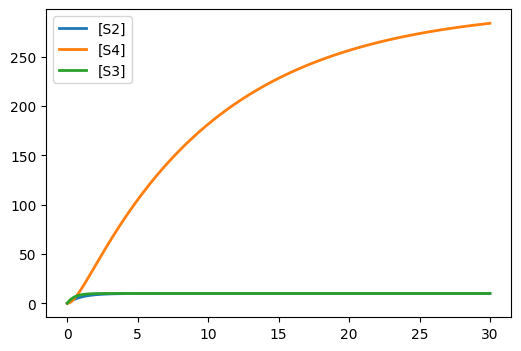

In [24]:
model3 = """
S1 -> S2; k1*S1
S2 -> S4; k2*S2
S1 -> S3; k3*S1
S3 -> S4; k4*S3
S4 -> ; k5*S4

k1 = 1
k2 =1
k3 =2
k4 = 2
k5 = 0.1
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR3 = te.loada(model3)
RR3.simulate(0, 30, 300)
RR3.plot()

**Questions**
1. What is the transfer function from $S_1$ to $S_4$?
1. What are the poles?
1. What are the zeros (values of $s$ that make the numerator of the transfer function 0)
1. What is the DC gain?

## Step 1-2: Write the Laplace Transforms of the system equations

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1 (s) - k_2 S_2 (s) \\
s S_3 (s) & = & k_3 S_1 (s) - k_4 S_3 (s) \\
s S_4 (s) & = & k_2 S_2 (s) + k_4 S_3 - k_5 S_4 \\
\end{eqnarray}

## Step 3: Solve for the output in terms of the input for each system equation

\begin{eqnarray}
S_2 (s) & = & \frac{k_1 S_1 (s)}{s + k_2} \\
S_3 (s) & = & \frac{k_3 S_1 (s)}{s + k_4} \\
S_4 (s) & = & \frac{k_2 S_2 (s)}{s + k_5} + \frac{k_4 S_3 (s)}{s + k_5}
\end{eqnarray}

## Step 4: Do backwards substitution to solve for the output in terms of the input

\begin{eqnarray}
S_4 (s) & = & \frac{k_2 }{s + k_5} S_2(s) + \frac{k_4 }{s + k_5} S_3(s) \\
& = & \frac{k_2}{s + k_5}\frac{k_1 }{s + k_2} S_1 (s) + \frac{k_4}{s + k_5} \frac{k_3 }{s + k_4} S_1 (s)\\
& = & \frac{k_1 k_2 (s+k_4) + k_3 k_4 (s+k_2)}{(s + k_5) (s + k_2) (s + k_4)} S_1 (s)\\
& = & \frac{(k_1 k_2 + k_3 k_4)s + k_1 k_2 k_4 + k_2 k_3 k_4 }{ (s + k_2) (s + k_4) (s + k_5)} S_1 (s)\\
\end{eqnarray}

## Step 5: Check your transfer function

4.953278702849451e-06

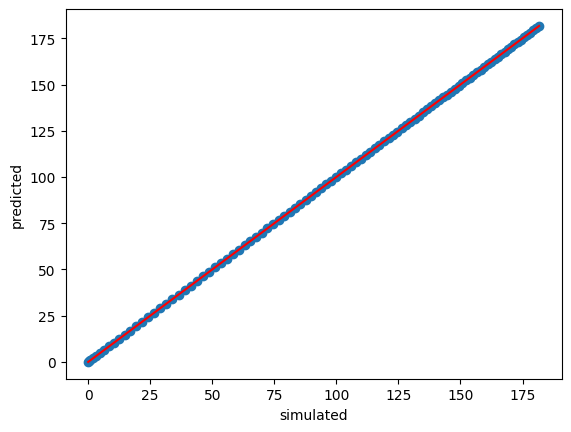

In [25]:
k1 = RR3["k1"]
k2 = RR3["k2"]
k3 = RR3["k3"]
k4 = RR3["k4"]
k5 = RR3["k5"]
scale = RR3["S1"]
tf = scale*((k1*k2 + k3*k4)*s + k1*k2*k4 + k2*k3*k4)/( (s+k2)*(s+k4)*(s+k5))
evaluateTransferFunction(model3, tf, "S4")

In [ ]:
evaluateTransferFunction(model3, tf, "S4")

# Using the transfer function for compensation

Compensation is the process of changing a system to improve its dynamic characteristics.

Example: Can we manipulate $k_1$ in the branching system to make the system faster? That his, S3 converges more quickly.

## Approach 1: Search for "good" values

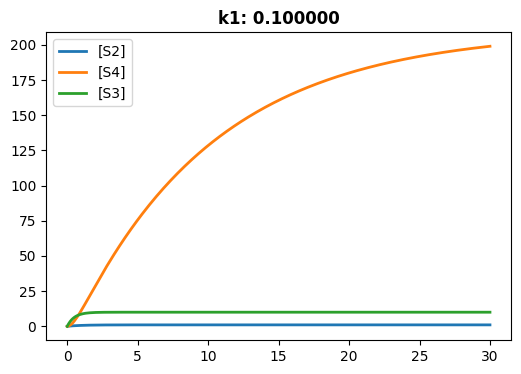

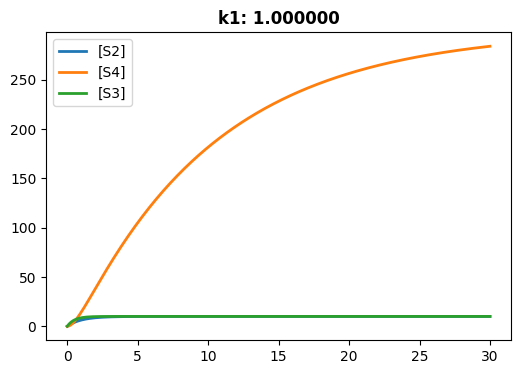

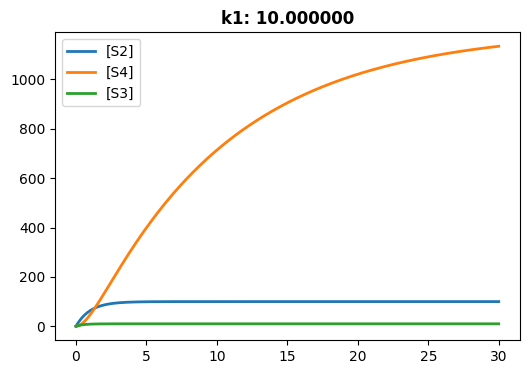

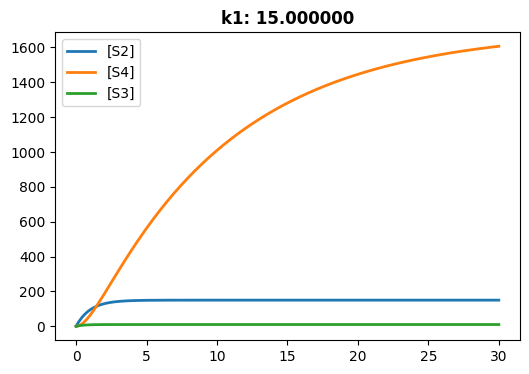

In [47]:
k1vals = [0.1, 1, 10, 15]
for idx, k1 in enumerate(k1vals):
    title = "k1: %f" % k1
    plotModel(model3, k1=k1, times=np.linspace(0, 30, 300), title=title)

## Approach 2: Use the transfer function

\begin{eqnarray}
G(s) & = & \frac{(k_1 k_2 + k_3 k_4)s + k_1 k_2 k_4 + k_2 k_3 k_4 }{ (s + k_2) (s + k_4) (s + k_5)}\\
\end{eqnarray}

In [48]:
# Look at the poles. Which causes the S4 to converge slowly?
k2, k4, k5

(2.0, 2.0, 0.1)

Idea: Find a value of $k_1$ such that the numerator equals to $s + k_5$ so that the pole "cancels".

\begin{eqnarray}
s + k_5 & = & s + \frac{k_1 k_2 k_4 + k_2 k_3 k_4}{k_1 k_2 + k_3 k_4} 
\\
k_5 & = & \frac{k_1 k_2 k_4 + k_2 k_3 k_4}{k_1 k_2 + k_3 k_4} 
\\
k_5(k_1 k_2 + k_3 k_4) & = & k_1 k_2 k_4 + k_2 k_3 k_4 
\\
k_1  & = &  \frac{k_2 k_3 k_4 - k_3 k_4 k_5}{ k_2 k_5 - k_2 k_4} \\
\end{eqnarray}

In [54]:
k1p = (k2*k3*k4 - k3*k4*k5)/( k2*k5 -k2*k4 )
k1p

-2.0

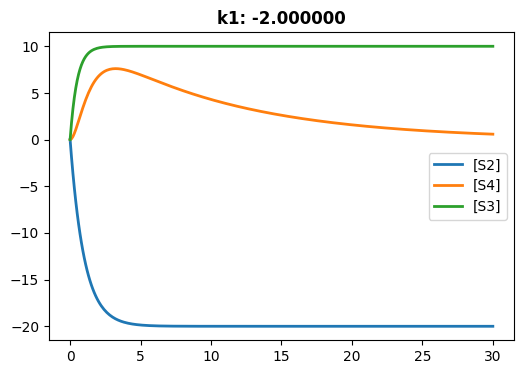

In [55]:
plotModel(model3, k1=k1p, times=np.linspace(0, 30, 300), title="k1: %f"%k1p)